In [74]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

# Data preparing

In [76]:
kf = KFold(n_splits=25, shuffle=True, random_state=42)
#cross_val_score(model, X, y, cv=kf, scoring='accuracy')

train_dataset = pd.read_csv('perceptron-train.csv', header=None)
test_dataset = pd.read_csv('perceptron-test.csv', header=None)

X_train = train_dataset.loc[:199,1]
y_train = train_dataset.loc[:199,2]

X_test = test_dataset.loc[:,1]
y_test = test_dataset.loc[:,2]

train_date = pd.date_range('1/1/2011', periods=200, freq='H') # just random
last_train_date = train_date[-1]
test_date = pd.date_range(last_train_date, periods=200, freq='H')

X_train.index = pd.DatetimeIndex(train_date)
y_train.index = pd.DatetimeIndex(train_date)

X_test.index = pd.DatetimeIndex(test_date)
y_test.index = pd.DatetimeIndex(test_date)

# <span style="color:red">Testing common SARIMAX algo</span>

/usr/lib64/python2.7/site-packages/statsmodels-0.8.0-py2.7-linux-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


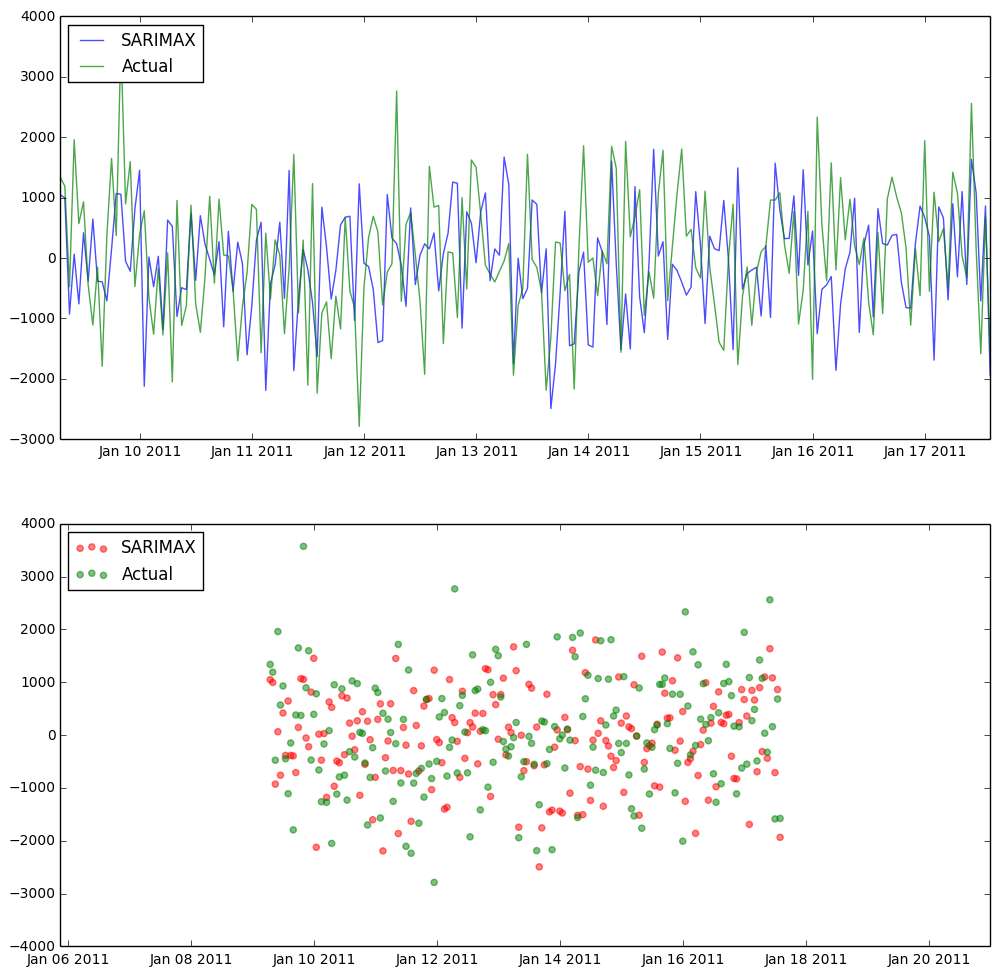

In [77]:
X_train.index = pd.DatetimeIndex(X_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

sarimax_model = sm.tsa.SARIMAX(X_train,y_train)
sarimax_model = sarimax_model.fit()

sarimax_prediction = np.array(list(sarimax_model.predict(exog=X_test)))*20896
test_date = np.array(test_date)

fig0 = plt.figure(figsize=(12,12))
a211 = fig0.add_subplot(211)
a211.plot(test_date, sarimax_prediction, color='blue', label='SARIMAX', alpha=0.7)
a211.plot(test_date, y_test, color='green', label='Actual', alpha=0.7)
a211.legend(loc='upper left')
a212 = fig0.add_subplot(212)
a212.scatter(test_date, sarimax_prediction, color='red', label='SARIMAX', alpha=0.5)
a212.scatter(test_date, y_test, color='green', label='Actual', alpha=0.5)
a212.legend(loc='upper left')
plt.show()

In [78]:
def count_relative_accuracy(predicted,actual):
    EPS = 200 # 1% value of error
    succes_counter = 0
    whole_size = len(actual)
    for i in range(len(actual)):
        if np.abs(predicted[i] - actual[i]) < EPS:
            succes_counter += 1
    return str(float(succes_counter)/whole_size*100)+'%'

sarimax_accuracy = np.mean(np.abs(np.array(y_test.values) - sarimax_prediction))
print sarimax_accuracy
print np.max(np.abs((np.array(y_test.values) - sarimax_prediction)))
print np.min(np.abs(np.array(y_test.values) - sarimax_prediction))
print count_relative_accuracy(sarimax_prediction,np.array(y_test.values))

1044.49369974
4016.56167501
0.509404769509
15.0%


# <span style="color:red">Custom model: SARIMAX + logreg</span>

In [79]:
i = 1
acc = -1
sarimax_prediction /= 20000
while True:
    sarimax_prediction *= i
    curr = count_relative_accuracy(sarimax_prediction,np.array(y_test.values))
    if acc > curr:
        print i
        break
    acc = curr
    i += 1

7


# Time series decomposition

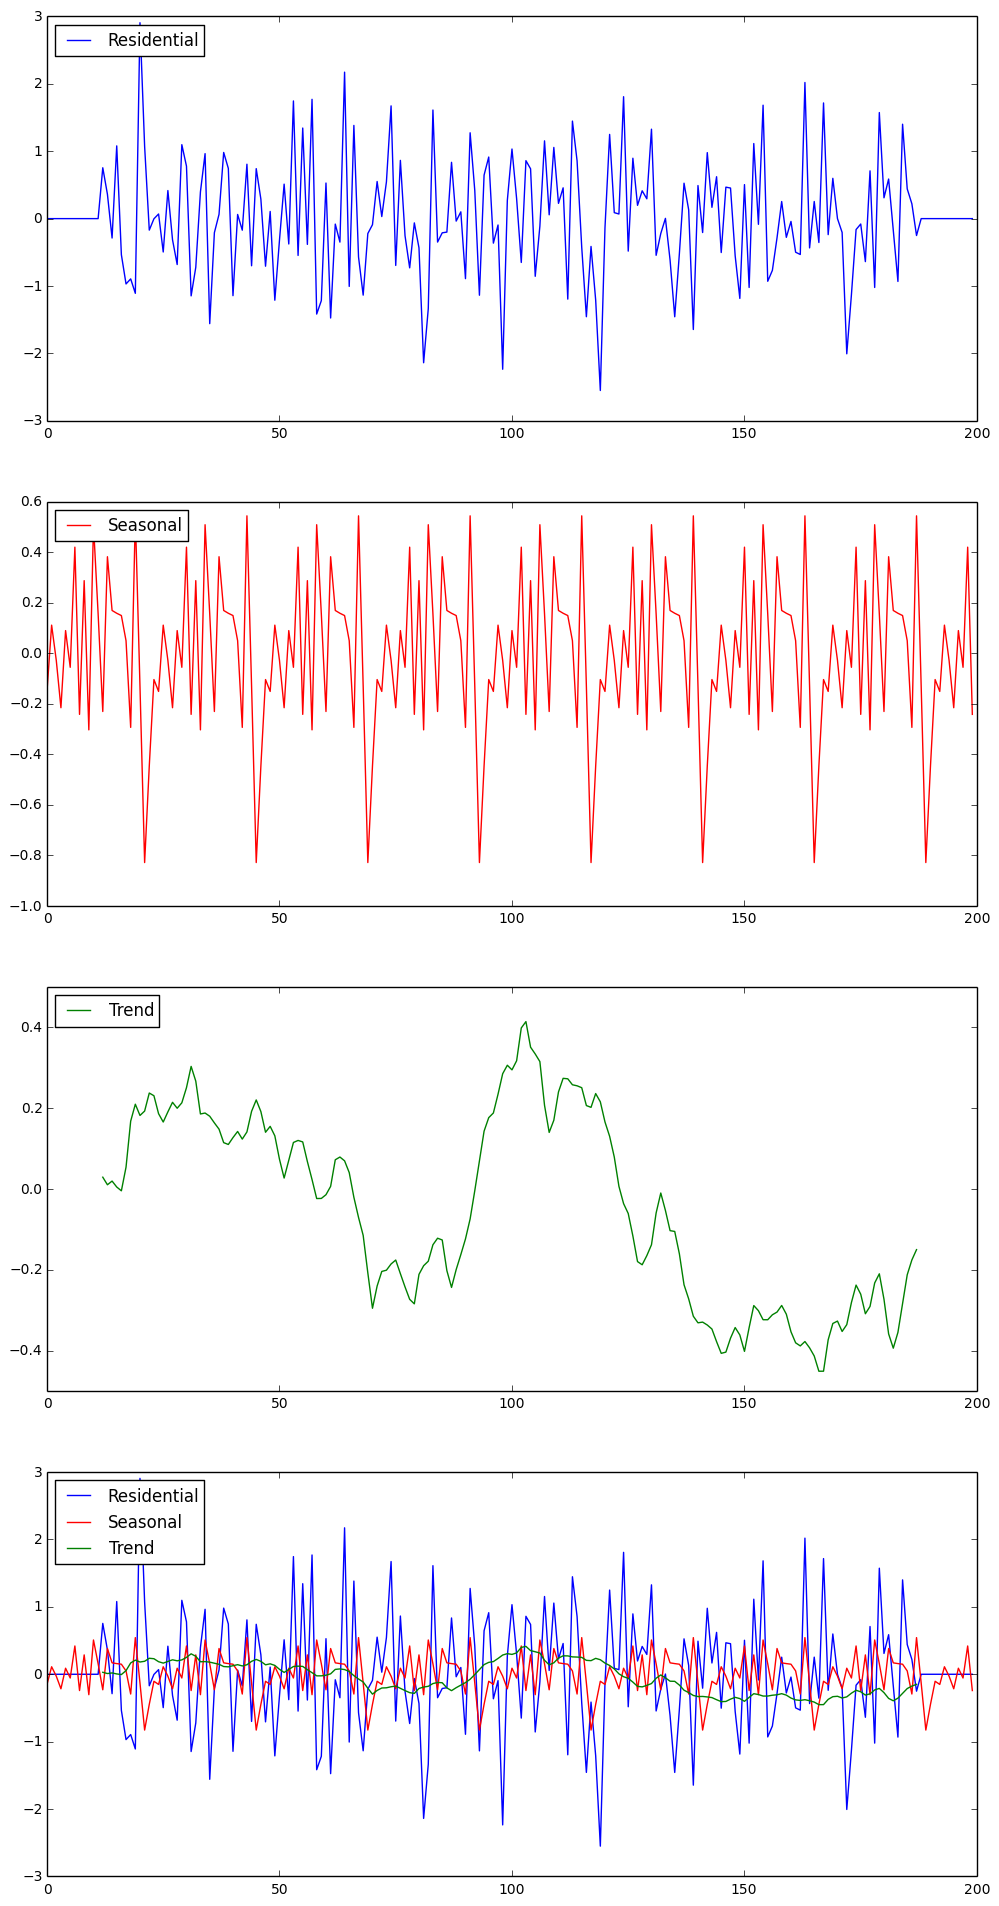

In [80]:
decomposed_X_test = sm.tsa.seasonal_decompose(X_test)
decomposed_X_test.resid.fillna(value=0, inplace=True)

fig = plt.figure(figsize=(12,24))
f411 = fig.add_subplot(411)
f411.plot(decomposed_X_test.resid, color="blue", label='Residential')
f411.legend(loc='upper left')
f412 = fig.add_subplot(412)
f412.plot(decomposed_X_test.seasonal, color="red", label='Seasonal')
f412.legend(loc='upper left')
f413 = fig.add_subplot(413)
f413.plot(decomposed_X_test.trend, color="green", label='Trend')
f413.legend(loc='upper left')
f414 = fig.add_subplot(414)
f414.plot(decomposed_X_test.resid, color="blue", label='Residential')
f414.plot(decomposed_X_test.seasonal, color="red", label='Seasonal')
f414.plot(decomposed_X_test.trend, color="green", label='Trend')
f414.legend(loc='upper left')
plt.show()

### Residential part for logistic regression

In [81]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [82]:
#logreg = LogisticRegression(penalty='l2', C=1.0, random_state=42)

decomposed_X_test.resid = decomposed_X_test.resid[:, None]

#X_train = X_train.reshape(len(X_train),1)

#logreg.fit(X_train, y_train)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = [0.0]
n_estimators = xrange(1, 51)
for n in n_estimators:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    score = np.mean(cross_val_score(model, np.array(decomposed_X_test.resid), np.array(decomposed_X_test.resid), cv=kf, scoring='r2'))
    scores.append(score)

In [83]:
scores = np.abs(np.array(scores))
print scores
print scores.tolist().index(np.max(scores))

[ 0.          0.99310294  0.99334733  0.99320515  0.99347984  0.99389661
  0.9942213   0.99411854  0.99435401  0.99442036  0.99446978  0.99453791
  0.99465409  0.99451095  0.9943555   0.99420273  0.9942476   0.99429625
  0.99428388  0.99428835  0.99433549  0.99438556  0.9944232   0.99445416
  0.99449269  0.99450273  0.99453275  0.9945555   0.99459378  0.99458485
  0.99461722  0.99464374  0.99464647  0.99462061  0.9946298   0.9946608
  0.99467473  0.99466863  0.99468468  0.99463756  0.99464835  0.99464501
  0.99463915  0.9946226   0.99463841  0.99465559  0.99466736  0.99464369
  0.99459081  0.99461381  0.99462949]
38


In [84]:
RF_model = RandomForestRegressor(n_estimators=39, random_state=42) # with optimal tree amount

In [86]:
decomposed_X_train = sm.tsa.seasonal_decompose(X_train)
decomposed_X_train.resid.fillna(value=0, inplace=True)

decomposed_y_train = sm.tsa.seasonal_decompose(y_train)
decomposed_y_train.resid.fillna(value=0, inplace=True)

decomposed_X_train.resid = decomposed_X_train.resid[:, None]

RF_model.fit(decomposed_X_train.resid, decomposed_y_train.resid)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=39, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [88]:
RF39_residential_prediction = RF_model.predict(decomposed_X_test.resid)

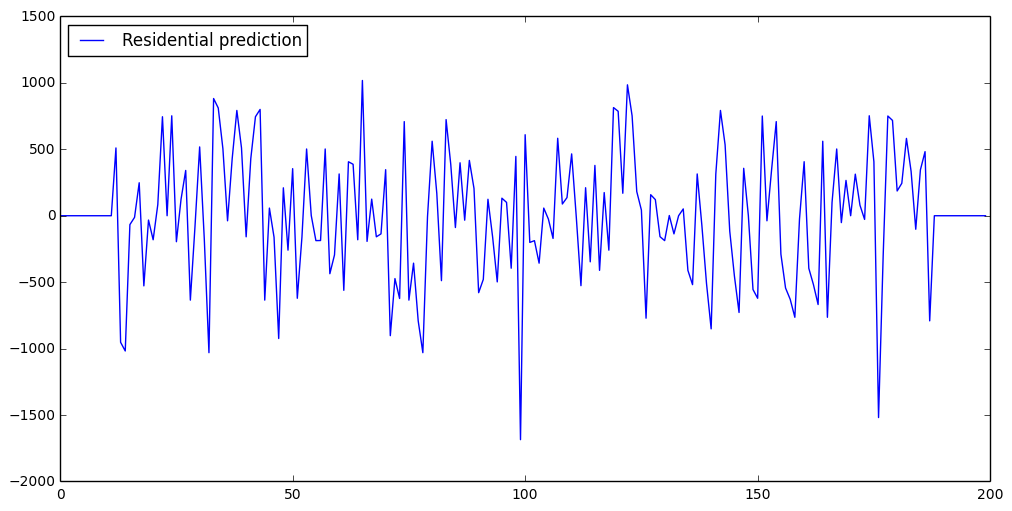

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.10178817e+02  -9.52579441e+02  -1.01794897e+03  -6.67415554e+01
  -1.23545433e+01   2.48160784e+02  -5.27992787e+02  -3.26153290e+01
  -1.80895219e+02   8.40955482e+01   7.45098137e+02   0.00000000e+00
   7.52120938e+02  -1.95607180e+02   1.23919089e+02   3.40846049e+02
  -6.35208017e+02  -7.99643467e+01   5.17923100e+02  -1.76661656e+02
  -1.03085504e+03   8.82252342e+02   8.10985355e+02   5.04382395e+02
  -3.81625577e+01   4.30598190e+02   7.92451481e+02   5.10178817e+02
  -1.58640082e+02   4.30598190e+02   7.45098137e+02   8.00058660e+02
  -6.35208017e+02   5.75308503e+01  -1.61872232e+02  -9.24041495e+02
   2.10107796e+02  -2.59123653e+02   3.54323611e+02  -6.21253479e+02
  -1.60216032e+02   5.02363503e+02   1.54828588e+00  -1.87325462e+02
  -1.86630316e+02   5.02363503e+02

In [93]:
fig = plt.figure(figsize=(12,6))
pl111 = fig.add_subplot(111)
pl111.plot(RF39_residential_prediction, label='Residential prediction')
pl111.legend(loc='upper left')
plt.show()

print RF39_residential_prediction

# Combining results

In [112]:
def combine(a,b): # b is for residential
    result = []
    for i in range(len(a)):
        result.append(a[i]+1.*np.sign(b[i])/(1.+np.log(np.abs(b[i]))))
    return np.array(result)

In [113]:
combined_prediction = pd.Series(np.nan_to_num(combined_prediciton))

combined_prediction.index = pd.DatetimeIndex(test_date)
combined_prediction.index = pd.DatetimeIndex(test_date)

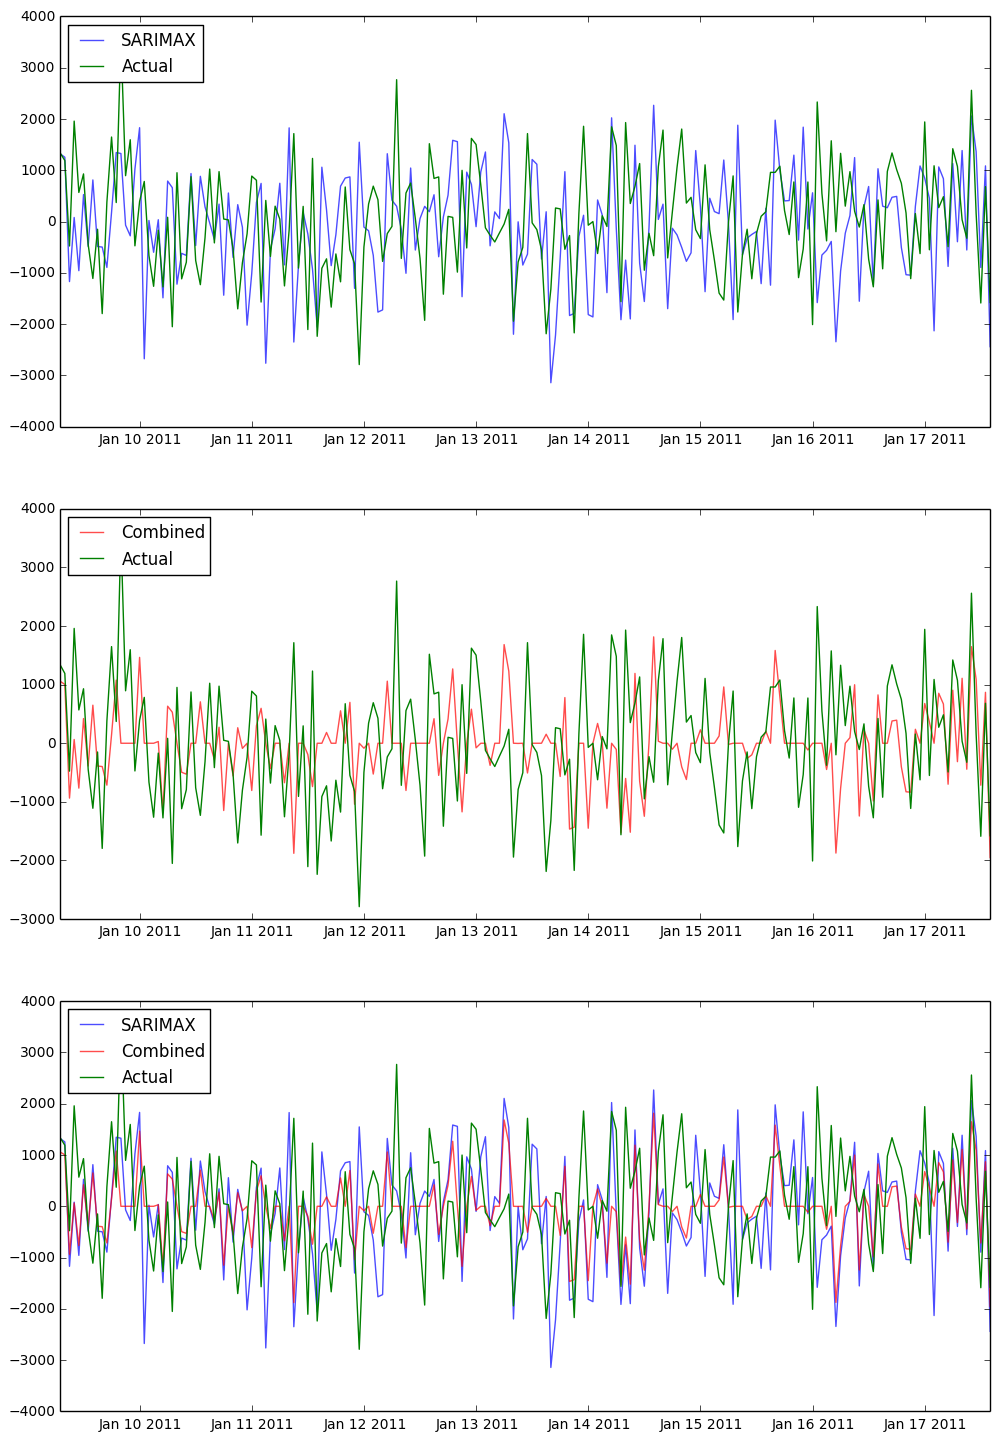

In [124]:
fig2 = plt.figure(figsize=(12,18))

b311 = fig2.add_subplot(311)
b311.plot(test_date, sarimax_prediction*5, color='blue', label='SARIMAX', alpha=0.7)
b311.plot(test_date, y_test, color='green', label='Actual')
b311.legend(loc='upper left')

b312 = fig2.add_subplot(312)
b312.plot(test_date, combined_prediction*4, color='red', label='Combined', alpha=0.7)
b312.plot(test_date, y_test, color='green', label='Actual')
b312.legend(loc='upper left')

b313 = fig2.add_subplot(313)
b313.plot(test_date, sarimax_prediction*5, color='blue', label='SARIMAX', alpha=0.7)
b313.plot(test_date, combined_prediction*4, color='red', label='Combined', alpha=0.7)
b313.plot(test_date, y_test, color='green', label='Actual')
b313.legend(loc='upper left')

plt.show()

In [128]:
print 'Common SARIMAX model:'
print sarimax_accuracy
print np.max(np.abs((np.array(y_test.values) - sarimax_prediction)))
print np.min(np.abs(np.array(y_test.values) - sarimax_prediction))
print count_relative_accuracy(sarimax_prediction,np.array(y_test.values))

print '\nCombined SARIMAX model and Random Forest on residential part:'
combined_accuracy = np.mean(np.abs(np.array(y_test.values) - combined_prediction))
print combined_accuracy
print np.max(np.abs((np.array(y_test.values) - combined_prediction)))
print np.min(np.abs(np.array(y_test.values) - combined_prediction))
print count_relative_accuracy(combined_prediction,np.array(y_test.values))

Common SARIMAX model:
1044.49369974
3306.06718217
1.67625354716
12.5%

Combined SARIMAX model and Random Forest on residential part:
840.058841643
3571.57921803
0.0755266106155
15.5%
